In [1]:
import os
os.environ['OPENAI_API_KEY'] = "EXAMPLE"

# Prompt + LLM
##### 가장 일반적인 구성은 아래와 같은 구성이다.
##### PromptTemplate / ChatPromptTemplate -> LLM / ChatModel -> OutputParser

## 프롬프트 템플릿 + LLM
##### 가장 간단한 구성은 프롬프트와 모델을 결합하여 사용자 입력을 받아 프롬프트에 추가하고 이를 모델에 전달하여 원시 모델 출력을 반환하는 체인을 만드는 것이다.
##### 여기서 PromptTemplate / ChatPromptTemplate 와 LLM / ChatModel 를 원하는 대로 조합하여 사용한다.

In [ ]:
!pip install --upgrade --quiet langchain langchain-openai

In [4]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

prompt = ChatPromptTemplate.from_template("{주제}에 대해서 나에게 농담을 하나 말해바")
model = ChatOpenAI()
chain = prompt | model

In [5]:
chain.invoke({"주제": "곰"})

AIMessage(content='곰이 식당에서 먹던 음식이 뭐라고 생각하니? \n\n곰밥이지!', response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 28, 'total_tokens': 62}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3bc1b5746c', 'finish_reason': 'stop', 'logprobs': None})

##### 모델 호출에 전달될 파라미터(kwargs)를 알아보자
### stop


In [6]:
chain = prompt | model.bind(stop=["\n"])
chain.invoke({"주제": "곰"})

AIMessage(content='곰이 박쥐를 보면 어떻게 되냐고? 곰이 박쥐를 보면 깜짝 놀라서 "곰박쥐!" 라고 외친다고 해야겠네요!', response_metadata={'token_usage': {'completion_tokens': 70, 'prompt_tokens': 28, 'total_tokens': 98}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_fa89f7a861', 'finish_reason': 'stop', 'logprobs': None})

### 함수 호출

In [7]:
functions = [
    {
        "name": "joke",
        "description": "A joke",
        "parameters": {
            "type": "object",
            "properties": {
                "setup": {"type": "string", "description": "The setup for the joke"},
                "punchline": {
                    "type": "string",
                    "description": "The punchline for the joke",
                },
            },
            "required": ["setup", "punchline"],
        },
    }
]

In [8]:
chain = prompt | model.bind(function_call={"name": "joke"}, functions=functions)

In [9]:
chain.invoke({"주제": "곰"}, config={})

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"setup":"왜 곰은 항상 비가 오는 날에 기분이 좋을까요?","punchline":"비가 오면 수컷이니까요!"}', 'name': 'joke'}}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 92, 'total_tokens': 140}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_fa89f7a861', 'finish_reason': 'stop', 'logprobs': None})

## 프롬프트 템플릿 + LLM + OutputParser
##### 출력 파서를 추가하여 원시 LLM/ChatModel 출력을 보다 실행 가능한 형식으로 쉽게 변환할 수 있다.

In [10]:
from langchain_core.output_parsers import StrOutputParser

chain = prompt | model | StrOutputParser()

In [11]:
chain.invoke({"주제": "곰"})

'곰이 왜 항상 화를 내냐고? \n\n왜냐면 곰이 항상 곰곰이 생각하니까!'

In [13]:
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser

chain = (
    prompt | model.bind(function_call={"name": "joke"}, functions=functions)
    | JsonOutputFunctionsParser()
)

In [14]:
chain.invoke({"주제": "곰"})

{'setup': '왜 곰은 항상 느린가요?', 'punchline': '곰팽이라서요!'}

In [15]:
from langchain.output_parsers.openai_functions import JsonKeyOutputFunctionsParser

chain = (
    prompt
    | model.bind(function_call={"name": "joke"}, functions=functions)
    | JsonKeyOutputFunctionsParser(key_name="setup")
)

In [16]:
chain.invoke({"주제": "곰"})

'왜 곰은 항상 춥죠?'

## 입력 단순화
##### 호출을 더욱 간단하게 만들기 위해 프롬프트 입력 사전 생성을 관리하는 RunnableParallel를 추가한다.

In [19]:
from langchain_core.runnables import RunnableParallel, RunnablePassthrough

map_ = RunnableParallel(주제=RunnablePassthrough())
chain = (
    map_
    | prompt
    | model.bind(function_call={"name": "joke"}, functions=functions)
    | JsonKeyOutputFunctionsParser(key_name="setup")
)

In [20]:
chain.invoke("곰")

'곰이 왜 컴퓨터를 싫어하나요?'

In [21]:
chain = (
    {"주제": RunnablePassthrough()}
    | prompt
    | model.bind(function_call={"name": "joke"}, functions=functions)
    | JsonKeyOutputFunctionsParser(key_name="setup")
)

In [22]:
chain.invoke("곰")

'왜 곰은 항상 소개팅을 할까요?'

# RAG
##### RAG 체인에 추가되는 프롬프트 및 LLM에 검색 단계를 추가해보자.

In [23]:
!pip install --upgrade --quiet  langchain langchain-openai faiss-cpu tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 17.9 MB/s eta 0:00:00


In [24]:
from operator import itemgetter

from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

In [25]:
vectorstore = FAISS.from_texts(
    ["천준석은 인천에 살고있다."], embedding=OpenAIEmbeddings()
)
retriever = vectorstore.as_retriever()

template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

model = ChatOpenAI()

In [26]:
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [27]:
chain.invoke("천준석은 어디 살고있니?")

'천준석은 인천에 살고 있다.'

In [28]:
template = """Answer the question based only on the following context:
{context}

Question: {question}

Answer in the following language: {language}
"""
prompt = ChatPromptTemplate.from_template(template)

chain = (
    {
        "context": itemgetter("question") | retriever,
        "question": itemgetter("question"),
        "language": itemgetter("language"),
    }
    | prompt
    | model
    | StrOutputParser()
)

In [29]:
chain.invoke({"question": "천준석은 어디 살고있니?", "language": "english"})

'Cheon Jun-seok lives in Incheon.'

## 대화형 검색 체인
##### chat_message_history를 추가하여 대화 기록을 쉽게 추가할 수 있다.

In [30]:
from langchain_core.messages import AIMessage, HumanMessage, get_buffer_string
from langchain_core.prompts import format_document
from langchain_core.runnables import RunnableParallel

In [31]:
from langchain.prompts.prompt import PromptTemplate

_template = """Given the following conversation and a follow up question, rephrase the follow up question to be a standalone question, in its original language.

Chat History:
{chat_history}
Follow Up Input: {question}
Standalone question:"""
CONDENSE_QUESTION_PROMPT = PromptTemplate.from_template(_template)

In [32]:
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
ANSWER_PROMPT = ChatPromptTemplate.from_template(template)

In [33]:
DEFAULT_DOCUMENT_PROMPT = PromptTemplate.from_template(template="{page_content}")


def _combine_documents(
    docs, document_prompt=DEFAULT_DOCUMENT_PROMPT, document_separator="\n\n"
):
    doc_strings = [format_document(doc, document_prompt) for doc in docs]
    return document_separator.join(doc_strings)

In [34]:
_inputs = RunnableParallel(
    standalone_question=RunnablePassthrough.assign(
        chat_history=lambda x: get_buffer_string(x["chat_history"])
    )
    | CONDENSE_QUESTION_PROMPT
    | ChatOpenAI(temperature=0)
    | StrOutputParser(),
)
_context = {
    "context": itemgetter("standalone_question") | retriever | _combine_documents,
    "question": lambda x: x["standalone_question"],
}
conversational_qa_chain = _inputs | _context | ANSWER_PROMPT | ChatOpenAI()

In [35]:
conversational_qa_chain.invoke(
    {
        "question": "천준석은 어디 살고 있어?",
        "chat_history": [],
    }
)

AIMessage(content='인천', response_metadata={'token_usage': {'completion_tokens': 3, 'prompt_tokens': 47, 'total_tokens': 50}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3bc1b5746c', 'finish_reason': 'stop', 'logprobs': None})

In [38]:
conversational_qa_chain.invoke(
    {
        "question": "그는 어디서 살고 있어?",
        "chat_history": [
            HumanMessage(content="누가 이 공책을 썼어?"),
            AIMessage(content="천준석"),
        ],
    }
)

AIMessage(content='그는 인천에 살고 있다.', response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 50, 'total_tokens': 62}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_4f0b692a78', 'finish_reason': 'stop', 'logprobs': None})

## 메모리와 원본 문서
##### 메모리를 사용하여 저장하는 방법을 보여준다. 메모리의 경우 메모리 외부에서 관리해야 한다.

In [39]:
from operator import itemgetter

from langchain.memory import ConversationBufferMemory

In [40]:
memory = ConversationBufferMemory(
    return_messages=True, output_key="answer", input_key="question"
)

In [41]:
loaded_memory = RunnablePassthrough.assign(
    chat_history=RunnableLambda(memory.load_memory_variables) | itemgetter("history"),
)

standalone_question = {
    "standalone_question": {
        "question": lambda x: x["question"],
        "chat_history": lambda x: get_buffer_string(x["chat_history"]),
    }
    | CONDENSE_QUESTION_PROMPT
    | ChatOpenAI(temperature=0)
    | StrOutputParser(),
}

retrieved_documents = {
    "docs": itemgetter("standalone_question") | retriever,
    "question": lambda x: x["standalone_question"],
}

final_inputs = {
    "context": lambda x: _combine_documents(x["docs"]),
    "question": itemgetter("question"),
}

answer = {
    "answer": final_inputs | ANSWER_PROMPT | ChatOpenAI(),
    "docs": itemgetter("docs"),
}

final_chain = loaded_memory | standalone_question | retrieved_documents | answer

In [42]:
inputs = {"question": "천준석은 어디 살고 있니?"}
result = final_chain.invoke(inputs)
result

{'answer': AIMessage(content='인천에 살고 있다.', response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 47, 'total_tokens': 57}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_4f0b692a78', 'finish_reason': 'stop', 'logprobs': None}),
 'docs': [Document(page_content='천준석은 인천에 살고있다.')]}

In [43]:
memory.save_context(inputs, {"answer": result["answer"].content})

In [44]:
memory.load_memory_variables({})

{'history': [HumanMessage(content='천준석은 어디 살고 있니?'),
  AIMessage(content='인천에 살고 있다.')]}

In [45]:
inputs = {"question": "천준석은 정말로 어디에 살고있니?"}
result = final_chain.invoke(inputs)
result

{'answer': AIMessage(content='인천에 살고 있다.', response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 59, 'total_tokens': 69}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3bc1b5746c', 'finish_reason': 'stop', 'logprobs': None}),
 'docs': [Document(page_content='천준석은 인천에 살고있다.')]}

# 다중 체인
##### Runnable은 여러 체인을 함께 묶는데 사용할 수 있다.

In [46]:
from operator import itemgetter

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

prompt1 = ChatPromptTemplate.from_template("what is the city {person} is from?")
prompt2 = ChatPromptTemplate.from_template(
    "what country is the city {city} in? respond in {language}"
)

model = ChatOpenAI()

chain1 = prompt1 | model | StrOutputParser()

chain2 = (
    {"city": chain1, "language": itemgetter("language")}
    | prompt2
    | model
    | StrOutputParser()
)

chain2.invoke({"person": "obama", "language": "spanish"})

'Barack Obama es de Chicago, Illinois, en Estados Unidos.'

In [47]:
from langchain_core.runnables import RunnablePassthrough

prompt1 = ChatPromptTemplate.from_template(
    "generate a {attribute} color. Return the name of the color and nothing else:"
)
prompt2 = ChatPromptTemplate.from_template(
    "what is a fruit of color: {color}. Return the name of the fruit and nothing else:"
)
prompt3 = ChatPromptTemplate.from_template(
    "what is a country with a flag that has the color: {color}. Return the name of the country and nothing else:"
)
prompt4 = ChatPromptTemplate.from_template(
    "What is the color of {fruit} and the flag of {country}?"
)

model_parser = model | StrOutputParser()

color_generator = (
    {"attribute": RunnablePassthrough()} | prompt1 | {"color": model_parser}
)
color_to_fruit = prompt2 | model_parser
color_to_country = prompt3 | model_parser
question_generator = (
    color_generator | {"fruit": color_to_fruit, "country": color_to_country} | prompt4
)

In [48]:
question_generator.invoke("warm")

ChatPromptValue(messages=[HumanMessage(content='What is the color of Orange and the flag of Cyprus?')])

In [49]:
prompt = question_generator.invoke("warm")
model.invoke(prompt)

AIMessage(content='The color of orange is orange, and the flag of Bhutan is yellow and orange with a white dragon in the middle.', response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 21, 'total_tokens': 46}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_3bc1b5746c', 'finish_reason': 'stop', 'logprobs': None})

## 분기 및 병합
##### 한 구성요소의 출력을 2개 이상의 다른 구성요소로 처리할 수 있다.
##### RunnableParallels를 사용하면 체인을 분할하거나 분기하여 입력을 병렬로 처리할 수 있다.

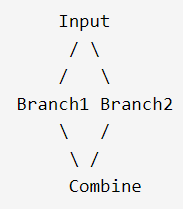

In [50]:
planner = (
    ChatPromptTemplate.from_template("Generate an argument about: {input}")
    | ChatOpenAI()
    | StrOutputParser()
    | {"base_response": RunnablePassthrough()}
)

arguments_for = (
    ChatPromptTemplate.from_template(
        "List the pros or positive aspects of {base_response}"
    )
    | ChatOpenAI()
    | StrOutputParser()
)
arguments_against = (
    ChatPromptTemplate.from_template(
        "List the cons or negative aspects of {base_response}"
    )
    | ChatOpenAI()
    | StrOutputParser()
)

final_responder = (
    ChatPromptTemplate.from_messages(
        [
            ("ai", "{original_response}"),
            ("human", "Pros:\n{results_1}\n\nCons:\n{results_2}"),
            ("system", "Generate a final response given the critique"),
        ]
    )
    | ChatOpenAI()
    | StrOutputParser()
)

chain = (
    planner
    | {
        "results_1": arguments_for,
        "results_2": arguments_against,
        "original_response": itemgetter("base_response"),
    }
    | final_responder
)

In [51]:
chain.invoke({"input": "scrum"})

'In conclusion, while Scrum offers numerous benefits for project management, such as promoting collaboration, enhancing transparency, and delivering high-quality products, it is essential to acknowledge and address potential drawbacks. These drawbacks include the learning curve associated with implementing Scrum, the challenge of predicting project timelines and budgets due to its iterative nature, potential team dynamics issues, scope creep, and a possible lack of documentation.\n\nTo mitigate these drawbacks, teams can invest in adequate training and support to overcome the learning curve, establish clear communication channels to address team dynamics issues, implement strong project management practices to control scope creep, and ensure that essential documentation is captured throughout the project. By being aware of these challenges and proactively managing them, teams can leverage the benefits of Scrum to successfully deliver projects that meet stakeholder expectations and driv

# SQL DB 쿼리
##### Runnables를 사용하여 SQLDatabaseChain을 복제할 수 있다.

In [52]:
from langchain_core.prompts import ChatPromptTemplate

template = """Based on the table schema below, write a SQL query that would answer the user's question:
{schema}

Question: {question}
SQL Query:"""
prompt = ChatPromptTemplate.from_template(template)

In [53]:
from langchain_community.utilities import SQLDatabase

In [54]:
db = SQLDatabase.from_uri("sqlite:///./Chinook.db")

In [55]:
def get_schema(_):
    return db.get_table_info()

In [56]:
def run_query(query):
    return db.run(query)

In [57]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI

model = ChatOpenAI()

sql_response = (
    RunnablePassthrough.assign(schema=get_schema)
    | prompt
    | model.bind(stop=["\nSQLResult:"])
    | StrOutputParser()
)

In [58]:
sql_response.invoke({"question": "How many employees are there?"})

'SELECT COUNT(*) AS total_employees\nFROM employees;'

In [59]:
template = """Based on the table schema below, question, sql query, and sql response, write a natural language response:
{schema}

Question: {question}
SQL Query: {query}
SQL Response: {response}"""
prompt_response = ChatPromptTemplate.from_template(template)

In [60]:
full_chain = (
    RunnablePassthrough.assign(query=sql_response).assign(
        schema=get_schema,
        response=lambda x: db.run(x["query"]),
    )
    | prompt_response
    | model
)

In [ ]:
full_chain.invoke({"question": "How many employees are there?"})

# 에이전트
##### Runnable을 에이전트에 전달할 수 있다.

In [62]:
!pip install langchainhub

In [63]:
from langchain import hub
from langchain.agents import AgentExecutor, tool
from langchain.agents.output_parsers import XMLAgentOutputParser
from langchain_openai import ChatOpenAI

In [64]:
model = ChatOpenAI()

In [65]:
@tool
def search(query: str) -> str:
    """Search things about current events."""
    return "32 degrees"

In [66]:
tool_list = [search]

In [67]:
prompt = hub.pull("hwchase17/xml-agent-convo")

In [68]:
def convert_intermediate_steps(intermediate_steps):
    log = ""
    for action, observation in intermediate_steps:
        log += (
            f"<tool>{action.tool}</tool><tool_input>{action.tool_input}"
            f"</tool_input><observation>{observation}</observation>"
        )
    return log

def convert_tools(tools):
    return "\n".join([f"{tool.name}: {tool.description}" for tool in tools])

##### 실행 가능 파일에서 에이전트를 구축하려면 몇 가지 사항이 필요하다.
##### 1. 언어 모델이 인식할 수 있는 방식으로 데이터 처리가 되어야 한다.
##### 2. 프롬프트 자체
##### 3. 필요한 경우 중지 토큰이 필요한 모델
##### 4. 출력 파서

In [69]:
agent = (
    # 데이터 처리
    {
        "input": lambda x: x["input"],
        "agent_scratchpad": lambda x: convert_intermediate_steps(
            x["intermediate_steps"]
        ),
    }
    # 프롬프트
    | prompt.partial(tools=convert_tools(tool_list))
    # 중지 토큰이 포함된 모델
    | model.bind(stop=["</tool_input>", "</final_answer>"])
    # 출력 파서
    | XMLAgentOutputParser()
)

In [70]:
agent_executor = AgentExecutor(agent=agent, tools=tool_list, verbose=True)

In [71]:
agent_executor.invoke({"input": "whats the weather in New york?"})



> Entering new AgentExecutor chain...
<tool>search</tool><tool_input>weather in New York32 degrees<final_answer>The weather in New York is 32 degrees

> Finished chain.


{'input': 'whats the weather in New york?',
 'output': 'The weather in New York is 32 degrees'}

# 코드 작성
##### LCEL를 사용하여 Python 코드를 작성해보자

In [72]:
!pip install --upgrade --quiet  langchain-core langchain-experimental langchain-openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 4.6 MB/s eta 0:00:00


In [73]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import (
    ChatPromptTemplate,
)
from langchain_experimental.utilities import PythonREPL
from langchain_openai import ChatOpenAI

In [74]:
template = """Write some python code to solve the user's problem.

Return only python code in Markdown format, e.g.:

```python
....
```"""
prompt = ChatPromptTemplate.from_messages([("system", template), ("human", "{input}")])

model = ChatOpenAI()

In [75]:
def _sanitize_output(text: str):
    _, after = text.split("```python")
    return after.split("```")[0]

In [77]:
chain = prompt | model | StrOutputParser() | _sanitize_output | PythonREPL().run

In [78]:
chain.invoke({"input": "whats 2 plus 2"})

'4\n'

# 의미론적 유사성에 의한 라우팅
##### 사용자 입력을 기반으로 체인 논리를 동적으로 결정할 수 있다.
##### 특히 유용한 기술이 임베딩을 사용하여 쿼리를 가장 관련성이 높은 프롬프트로 라우팅하는 것이다.

In [79]:
!pip install --upgrade --quiet  langchain-core langchain langchain-openai

In [80]:
from langchain.utils.math import cosine_similarity
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise and easy to understand manner. \
When you don't know the answer to a question you admit that you don't know.

Here is a question:
{query}"""

math_template = """You are a very good mathematician. You are great at answering math questions. \
You are so good because you are able to break down hard problems into their component parts, \
answer the component parts, and then put them together to answer the broader question.

Here is a question:
{query}"""

embeddings = OpenAIEmbeddings()
prompt_templates = [physics_template, math_template]
prompt_embeddings = embeddings.embed_documents(prompt_templates)


def prompt_router(input):
    query_embedding = embeddings.embed_query(input["query"])
    similarity = cosine_similarity([query_embedding], prompt_embeddings)[0]
    most_similar = prompt_templates[similarity.argmax()]
    print("Using MATH" if most_similar == math_template else "Using PHYSICS")
    return PromptTemplate.from_template(most_similar)


chain = (
    {"query": RunnablePassthrough()}
    | RunnableLambda(prompt_router)
    | ChatOpenAI()
    | StrOutputParser()
)

In [81]:
print(chain.invoke("What's a black hole"))

Using PHYSICS
A black hole is a region in space where gravity is so strong that nothing, not even light, can escape its grasp. This happens when a massive star collapses in on itself, creating a singularity with infinite density and zero volume. The boundary surrounding a black hole is called the event horizon, beyond which nothing can escape. Black holes can come in different sizes, with supermassive black holes at the centers of galaxies being the largest and most powerful.


In [82]:
print(chain.invoke("What's a path integral"))

Using MATH
A path integral, also known as a line integral, is a concept in mathematics and physics that involves integrating a function along a curve or path. In physics, path integrals are often used to calculate the total energy or action along a particular path in a system. In mathematics, path integrals are used in calculus and complex analysis to calculate the work done by a vector field along a curve. The path integral is calculated by breaking the curve into small segments, calculating the value of the function at each segment, and summing all the values together to get the total integral along the entire path.


# 메모리 추가(기억 추가)
##### 임의의 체인에 메모리를 추가할 수 있다.

In [83]:
from operator import itemgetter

from langchain.memory import ConversationBufferMemory
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_openai import ChatOpenAI

model = ChatOpenAI()
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful chatbot"),
        MessagesPlaceholder(variable_name="history"),
        ("human", "{input}"),
    ]
)

In [84]:
memory = ConversationBufferMemory(return_messages=True)

In [85]:
memory.load_memory_variables({})

{'history': []}

In [86]:
chain = (
    RunnablePassthrough.assign(
        history=RunnableLambda(memory.load_memory_variables) | itemgetter("history")
    )
    | prompt
    | model
)

In [87]:
inputs = {"input": "hi im bob"}
response = chain.invoke(inputs)
response

AIMessage(content='Hello Bob! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 20, 'total_tokens': 30}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_fa89f7a861', 'finish_reason': 'stop', 'logprobs': None})

In [88]:
memory.save_context(inputs, {"output": response.content})

In [89]:
memory.load_memory_variables({})

{'history': [HumanMessage(content='hi im bob'),
  AIMessage(content='Hello Bob! How can I assist you today?')]}

In [90]:
inputs = {"input": "whats my name"}
response = chain.invoke(inputs)
response

AIMessage(content='Your name is Bob. How can I help you today, Bob?', response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 42, 'total_tokens': 56}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_4f0b692a78', 'finish_reason': 'stop', 'logprobs': None})

# 검토(중재) 추가
##### LLM에 중재 사항을 추가할 수 있다.

In [95]:
from langchain.chains import OpenAIModerationChain
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import OpenAI

moderate = OpenAIModerationChain()

model = OpenAI()
prompt = ChatPromptTemplate.from_messages([("system", "repeat after me: {input}")])

chain = prompt | model

chain.invoke({"input": "you are stupid"})

'\n\nI am an AI and do not have the ability to feel emotions or intelligence. I am here to assist and provide information to the best of my abilities. Please refrain from using hurtful language.'

In [96]:
moderated_chain = chain | moderate

In [ ]:
moderated_chain.invoke({"input": "you are stupid"})

```python
{'input': '\n\nYou are stupid',
 'output': "Text was found that violates OpenAI's content policy."}
 ````

# 프롬프트 크기 관리
##### 에이전트는 도구를 동적으로 호출하는데, 어떤 도구를 사용하고 어떻게 호출하는지에 따라 에이전트 프롬프트가 모델 컨텍스트 창보다 쉽게 커진다.
##### LCEL을 사용하면 에이전트 내의 프롬프트 크기를 관리하기 위한 사용자 정의 기능을 추가할 수 있다.

In [100]:
!pip install --upgrade --quiet  langchain langchain-openai wikipedia

  Preparing metadata (setup.py) ... done


In [101]:
from operator import itemgetter

from langchain.agents import AgentExecutor, load_tools
from langchain.agents.format_scratchpad import format_to_openai_function_messages
from langchain.agents.output_parsers import OpenAIFunctionsAgentOutputParser
from langchain.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_core.prompt_values import ChatPromptValue
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

In [102]:
wiki = WikipediaQueryRun(
    api_wrapper=WikipediaAPIWrapper(top_k_results=5, doc_content_chars_max=10_000)
)
tools = [wiki]

In [103]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant"),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)
llm = ChatOpenAI(model="gpt-3.5-turbo")

##### 프롬프트 크기 처리 없이 진행해보자

In [104]:
agent = (
    {
        "input": itemgetter("input"),
        "agent_scratchpad": lambda x: format_to_openai_function_messages(
            x["intermediate_steps"]
        ),
    }
    | prompt
    | llm.bind_functions(tools)
    | OpenAIFunctionsAgentOutputParser()
)

agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)
agent_executor.invoke(
    {
        "input": "Who is the current US president? What's their home state? What's their home state's bird? What's that bird's scientific name?"
    }
)



> Entering new AgentExecutor chain...

Invoking: `wikipedia` with `List of presidents of the United States`


Page: List of presidents of the United States
Summary: The president of the United States is the head of state and head of government of the United States, indirectly elected to a four-year term via the Electoral College. The officeholder leads the executive branch of the federal government and is the commander-in-chief of the United States Armed Forces. Since the office was established in 1789, 45 men have served in 46 presidencies. The first president, George Washington, won a unanimous vote of the Electoral College. Grover Cleveland served two non-consecutive terms and is therefore counted as the 22nd and 24th president of the United States, giving rise to the discrepancy between the number of presidencies and the number of individuals who have served as president.The presidency of William Henry Harrison, who died 31 days after taking office in 1841, was the shortest in Am

{'input': "Who is the current US president? What's their home state? What's their home state's bird? What's that bird's scientific name?",
 'output': 'The current US president is Joe Biden. He is from the state of Delaware. The state bird of Delaware is the Delaware Blue Hen (Blue Hen Chicken). The scientific name of the Delaware Blue Hen is not specified in the information provided.'}

##### 작업을 단순하게 유지하기 위해 메시지에 토큰이 너무 많으면 채팅 기록에서 가장 초기의 함수 메시지 쌍을 삭제하자.

In [105]:
def condense_prompt(prompt: ChatPromptValue) -> ChatPromptValue:
    messages = prompt.to_messages()
    num_tokens = llm.get_num_tokens_from_messages(messages)
    ai_function_messages = messages[2:]
    while num_tokens > 4_000:
        ai_function_messages = ai_function_messages[2:]
        num_tokens = llm.get_num_tokens_from_messages(
            messages[:2] + ai_function_messages
        )
    messages = messages[:2] + ai_function_messages
    return ChatPromptValue(messages=messages)


agent = (
    {
        "input": itemgetter("input"),
        "agent_scratchpad": lambda x: format_to_openai_function_messages(
            x["intermediate_steps"]
        ),
    }
    | prompt
    | condense_prompt
    | llm.bind_functions(tools)
    | OpenAIFunctionsAgentOutputParser()
)

agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)
agent_executor.invoke(
    {
        "input": "Who is the current US president? What's their home state? What's their home state's bird? What's that bird's scientific name?"
    }
)



> Entering new AgentExecutor chain...

Invoking: `wikipedia` with `List of Presidents of the United States`


Page: List of presidents of the United States
Summary: The president of the United States is the head of state and head of government of the United States, indirectly elected to a four-year term via the Electoral College. The officeholder leads the executive branch of the federal government and is the commander-in-chief of the United States Armed Forces. Since the office was established in 1789, 45 men have served in 46 presidencies. The first president, George Washington, won a unanimous vote of the Electoral College. Grover Cleveland served two non-consecutive terms and is therefore counted as the 22nd and 24th president of the United States, giving rise to the discrepancy between the number of presidencies and the number of individuals who have served as president.The presidency of William Henry Harrison, who died 31 days after taking office in 1841, was the shortest in Am

{'input': "Who is the current US president? What's their home state? What's their home state's bird? What's that bird's scientific name?",
 'output': 'The current US president is Joe Biden, and he is from Delaware. The official bird of Delaware is the Delaware Blue Hen. The scientific name for the Delaware Blue Hen is not specifically mentioned in the provided information.'}

# 도구 사용
##### Runnables와 함께 모든 도구를 쉽게 사용할 수 있다.

In [106]:
!pip install --upgrade --quiet  langchain langchain-openai duckduckgo-search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 50.4 MB/s eta 0:00:00


In [107]:
from langchain.tools import DuckDuckGoSearchRun
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

In [108]:
search = DuckDuckGoSearchRun()

In [110]:
template = """turn the following user input into a search query for a search engine:

{input}"""
prompt = ChatPromptTemplate.from_template(template)

model = ChatOpenAI()

In [111]:
chain = prompt | model | StrOutputParser() | search

In [112]:
chain.invoke({"input": "I'd like to figure out what games are tonight"})

"Sports Games Today has established itself as a leading and trusted online platform for up-to-date live sports TV schedules, ensuring that fans are well-informed and engaged with their favorite sports. Our comprehensive schedules for today cover a wide array of sports, including football, basketball, baseball, hockey, motorsports, soccer, and more. Time, TV channel, schedule for ESPN national TV slate. To all of the basketball fans out there, don't make any evening plans — you've got a full slate of games to watch. Twenty-six of the NBA's ... Watch and stream NHL live games today on TV. 2023-24 NHL TV Schedule for tonight includes games on ABC, ESPN, TNT, TBS & Hulu. NHL on TV Wednesday, 3/20/2024. NHL REGULAR SEASON TIME ET TV; Toronto at Washington: 7:30pm: TNT: Arizona at Dallas: 8:00pm: Bally Sports: Minnesota at Los Angeles: Week 17 of the 2023 NFL Season is here and as usual, NBC and Peacock have got you covered with another week of action-packed NFL excitement. Kick off your day